In [1]:
import deepinv as dinv
from pathlib import Path
import torch
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves

In [2]:
BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"

In [3]:
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
# Set up the variable to fetch dataset and operators.
method = "PnP"
img_size = 32
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
# supress saturated pixels to avoid reconstruction issues using torch.angle()
x = torch.where(x > 0.99999, 0.99999, x)
x = torch.where(x < 0.00001, 0.00001, x)
operation = "tomography"

In [4]:
img_shape = x.shape[1:]
m = 5 * torch.prod(torch.tensor(img_shape))

In [6]:
noise_level_img = 0.03  # Gaussian Noise standard deviation for the degradation
n_channels = 1  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.CompressedSensing(
    m=m,
    img_shape=img_shape,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers = 4 if torch.cuda.is_available() else 0

In [7]:
y = physics(x)
x_lin = physics.A_adjoint(y)
y.shape

torch.Size([1, 5120])

In [80]:
params_algo = {"stepsize": 0.45, "g_param": noise_level_img}
max_iter = 100
early_stop = True

In [81]:
# Select the data fidelity term
data_fidelity = L2()

# Specify the denoising prior
denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    train=False,
    device=device,
)
prior = PnP(denoiser=denoiser)

# Logging parameters
verbose = True
plot_metrics = True  # compute performance and convergence metrics along the algorithm, curved saved in RESULTS_DIR

# instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
)

In [82]:
# run the model on the problem.
x_model, metrics = model(
    y, physics, x_gt=x, compute_metrics=True
)  # reconstruction with PnP algorithm

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(f"PnP reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_model):.2f} dB")

Iteration 19, current converge crit. = 8.27E-06, objective = 1.00E-05 
Linear reconstruction PSNR: 20.61 dB
PnP reconstruction PSNR: 38.95 dB


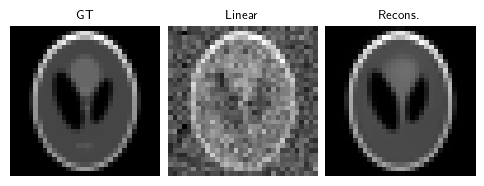

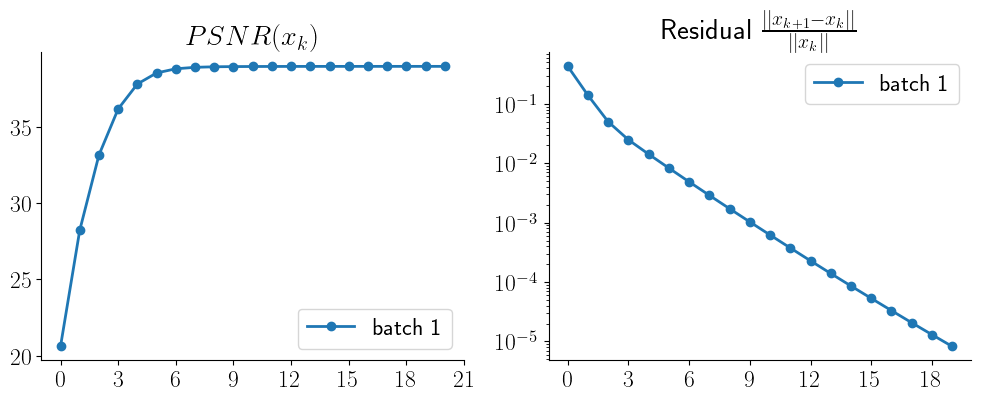

In [83]:
# plot images. Images are saved in RESULTS_DIR.
imgs = [x, x_lin, x_model]
plot(
    imgs,
    titles=["GT", "Linear", "Recons."],
    save_dir=RESULTS_DIR / "images",
    show=True,
)

# plot convergence curves. Metrics are saved in RESULTS_DIR.
if plot_metrics:
    plot_curves(metrics, save_dir=RESULTS_DIR / "curves", show=True)